# Setup

📝 *Import required libraries and files:*

In [1]:
import pandas as pd
import numpy as np
from time import time

# 4.1. cleaning and preprocess
import re
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# 4.2. & 4.3. topic modeling
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import json, joblib

In [2]:
path = "../assets/df_sentiment.parquet"
df_sentiment = pd.read_parquet(path)
print(f"df shape: {df_sentiment.shape}")
df_sentiment.head(2)

df shape: (703563, 20)


,review_id,app,score,review_text,review_text_clean,review_date,year,thumbs_up,replied,reply_text,reply_text_clean,reply_date,time_to_reply(h),app_version_head,app_version_detail,review_sentiment,review_sentiment_label,Consistent,reply_sentiment,reply_sentiment_label
0,1,Santander,5,"very easy to use app, very happy with it","very easy to use app, very happy with it",2025-09-04 14:21:00,2025,0,1,"Hi! Thanks for the 5* review, we're so glad to...","hi! thanks for the 5* review, we're so glad to...",2025-09-04 14:40:12,0.32,5,24.0,0.8012,positive,1,0.8767,positive
1,2,Santander,3,New 2024 app is slow to open. Too much whitesp...,new 2024 app is slow to open. too much whitesp...,2025-09-04 13:36:26,2025,3,1,Hey there! All feedback is greatly appreciated...,hey there! all feedback is greatly appreciated...,2024-04-29 14:16:29,-11831.33,5,24.0,-0.9020,negative,1,0.8930,positive


# 4 - Topic Modeling

## 4.1. - Model Training

The goal of this notebook is to identify frequent **pain points** mentioned by comments with negative reviews, as well as the **strenghts** addressed in positive reviews. We will focus on **user reviews** (i.e., discarting bank's replies) and we will **discart inconsistent cases** - e.g., reviews with negative scores but positive sentiment, or vice versa.

We will work with a copy of `df_sentiment` and encapsulate all the transformations in the end to facilitate reproducibility.

In [3]:
df = df_sentiment.copy()

### 4.1.1. - Text cleaning and preprocessing

Text cleaning and preprocessing is an essential step to get meaningful topics. 

First of all, all **inconsistent cases will be removed** - i.e., reviews with inconsistent score and sentiment.

In [4]:
print(f"Shape before removal of inconsistent cases: {df.shape}")

# Remove contradictory rows
df_model = df[df['Consistent']==1].copy()

print(f"Shape after of inconsistent cases: {df_model.shape}")

Shape before removal of inconsistent cases: (813103, 20)
Shape after of inconsistent cases: (774649, 20)


Below we **perform text cleaning and preprocess**. A copy of original texts is kept in 'text' to allow later interpretation.

In [5]:
# Additional text cleaning / prior cleaning was already done in the cleaning function in notebook 2
def text_cleaner(x):
    if not isinstance(x, str):
        return pd.NA
    t = x
    t = re.sub(r'@\w+', ' ', t)                 # remove @mentions
    t = re.sub(r'\d+', ' <num> ', t)            # numbers -> <num>
    t = re.sub(r'[^a-z\s<>]+', ' ', t)          # keep letters, spaces, and <> so <num> survives
    t = re.sub(r'\s+', ' ', t).strip()          # normalize whitespace
    return t if t else pd.NA

# Apply cleaning
df_model['review_extra_clean'] = df_model['review_text_clean'].map(text_cleaner)

print(f"Shape after text_cleaner: {df_model.shape}")

Shape after text_cleaner: (774649, 21)


In [6]:
# Drop ultra-short reviews (fewer than 2 tokens)
df_model = df_model[df_model['review_extra_clean'].str.split().str.len() >= 2]

print(f"Shape after removing ultra-short reviews: {df_model.shape}")

Shape after removing ultra-short reviews: (674085, 21)


In [7]:
# Remove stop words --> words that can occur frequently but do not provide useful insight in the context of this analysis

# Domain stopwords
domain_sw = {
    'app','apps','bank','account','application', 'mobile', 'banks', 'santander', 'uk', 
    'lloyds', 'hsbc', 'revolut', 'barclays', 'monzo', 'banks', 'thanks', 'ive', 'num',
}

# Merge English + domain stopwords into a list
stop_words = list(ENGLISH_STOP_WORDS.union(domain_sw))

### 4.1.2. - LDA trained with ALL reviews

We will use **LDA (Latent Dirichlet Allocation)** for topic modeling. LDA is a **generative probabilistic model** prepared to discover hidden topics in a colleciton of documents - i.e., our reviews in this case. In short, LDA defines topics according to word distribution, and then represents each document (i.e., review) as a probability distribution over those topics.

The following modeling **3-staged approach** will be used for LDA training and finetune:
1. Run LDA with 10 topics and evaluate top words for each of the 10 topics
2. Finetune 'stop words', removing top words that do not generate additional value, and re-run LDA
3. Test different `n` topics and Select best (i.e., more interpretable) number of topics and assign dominant topic for each review

**I. INITIAL RUN OF LDA WITH 10 TOPICS**

First of all, we'll **define functions** to build the vectorizer, run the LDA and print the results, to ensure future reproducibility.

Note: For **vectorization** (i.e. transform text into a document-term matrix - DTM) we will use **Count Vectorizer Bag-of-Words** which is best **suited for LDA** (Latent Dirichlet Allocation) we inted to use in the next stage.

In [8]:
# Build vectorizer in case you've updated stopwords later
def build_vectorizer(stop_words, ngram_range=(1,2), min_df=20, max_df=0.5):
    return CountVectorizer(
        preprocessor=None,
        token_pattern=r'(?u)\b[a-z<][a-z<>-]{2,}\b',
        stop_words=stop_words,
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df
    )

# Run LDA
def fit_lda(X, n_topics=10, max_iter=10, random_state=42, n_jobs=-1):
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=max_iter,
        learning_method='batch',
        random_state=random_state,
        n_jobs=n_jobs
    )
    t0 = time()
    lda.fit(X)
    print(f"LDA fit done: {n_topics} topics in {time() - t0:.1f}s")
    return lda

# Print Top Words
def print_top_words(model, feature_names, n_top=12, title=None):
    if title:
        print(title)
    for t, comp in enumerate(model.components_):
        top_idx = comp.argsort()[-n_top:][::-1]
        print(f"Topic {t:02d}: " + " | ".join(feature_names[top_idx]))
    print()

Now we can run the model testing first for 10 topics.

In [9]:
# Build X for baseline run (10 topics)
vectorizer = build_vectorizer(stop_words)      
X = vectorizer.fit_transform(df_model['review_extra_clean'])
vocab = vectorizer.get_feature_names_out() # used later on to print top words

In [10]:
# Run LDA
lda_10 = fit_lda(X, n_topics=10)

LDA fit done: 10 topics in 1287.4s


Now let's see what are the top words for each topic:

In [11]:
print_top_words(lda_10, vocab, n_top=12)

Topic 00: easy | use | easy use | quick | simple | quick easy | great | secure | convenient | safe | great easy | fast
Topic 01: banking | best | transfer | online | money | accounts | transfer money | online banking | great | check | day | manage
Topic 02: phone | update | work | log | doesnt | love | working | just | doesnt work | use | screen | new
Topic 03: just | dont | open | time | update | new | support | wont | customer | help | card | days
Topic 04: great | money | far | card | amazing | exchange | nice | recommend | abroad | better | rates | using
Topic 05: works | time | problems | love | great | just | using | lot | use | handy | banking | easier
Topic 06: easy | payments | makes | card | easier | life | make | navigate | accounts | easy navigate | transfers | track
Topic 07: good | like | really | fast | dont | pay | reliable | really good | efficient | service | good service | pretty
Topic 08: useful | user | friendly | helpful | brilliant | user friendly | quick | reall

As we can see from above there are still too many words that do not generate any additional value / insight that need to be removed (i.e., added to the stop words) in order not to polute the topic modeling and to extract meaningfull insights.

**II. Finetune stopwords and re-run LDA**

Adding new words that are poluting topics to `stop_words` --> 📌 this process was repeated for several times in this project.

In [12]:
domain_extra = {
    'able', 'absolutely', 'accounts', 'add', 'ago', 'alot', 'allows', 'amazing', 'anymore', 'appropriate','awesome', 'bad', 'banking', 
    'best', 'better', 'bit', 'branch', 'brilliant', 'business', 'change', 'cheque', 'cheques','clear', 'close', 'complicated', 
    'convenient', 'constantly', 'daily', 'date', 'day', 'days', 'definitely', 'did', 'didnt', 'different', 'difficult', 'does', 
    'doesnt', 'doing', 'dont', 'ease', 'easier', 'easily', 'easy', 'effective', 'efficient', 'especially', 'exactly', 'excellent', 
    'experience', 'extremely', 'fab', 'fantastic', 'far', 'fast', 'feels','finances', 'fine', 'fix', 'follow', 'forward', 'getting', 
    'gives', 'going', 'good', 'google', 'got', 'great', 'guys', 'handy', 'happy', 'havent', 'having', 'hassle', 'hello', 'helpful', 
    'helps', 'highly', 'hope', 'hoping', 'improved', 'isnt', 'issues', 'job', 'just','keeping', 'keeps', 'know', 'latest', 'let', 
    'lets', 'life', 'like', 'little', 'live', 'long', 'longer', 'lot', 'lots', 'love', 'loving','make', 'makes', 'making', 'month', 
    'months', 'need', 'needed', 'needs', 'neo', 'new', 'nice', 'number', 'old', 'online','open', 'overall', 'payees', 'pending', 
    'people', 'perfect', 'perfectly', 'place', 'pleased', 'poor', 'pretty', 'quick', 'quickly', 'quite', 'really', 'reason', 
    'recommend', 'recommended', 'reliable', 'rooted', 'round', 'rubbish', 'safe', 'satisfied', 'saves', 'say', 'says', 'set', 
    'simple', 'simpler', 'simply', 'slow', 'smooth', 'sort', 'star', 'stars', 'stopped', 'straighforward', 'straight', 
    'straightforward', 'stuff', 'super', 'superb', 'sure', 'takes', 'team', 'terrible', 'thank', 'thats', 'think', 'thing', 
    'things', 'time', 'times', 'tin', 'tried', 'try', 'trying', 'unable', 'understand', 'use', 'used', 'useful', 'useless', 
    'using', 'usually', 'want', 'way', 'website', 'went', 'whats', 'wish', 'wonderful', 'wont', 'work', 'worked', 'working', 'works', 
    'worst', 'wrong', 'years'
}

stop_words = list(set(stop_words).union(domain_extra))

Remove reviews that are exclusively stop words.

In [13]:
tmp_vec = CountVectorizer(
    preprocessor=None,
    token_pattern=r'(?u)\b[a-z<][a-z<>-]{2,}\b',
    stop_words=stop_words,
    ngram_range=(1,1)
)
analyze = tmp_vec.build_analyzer()

min_tokens_after_sw = 1
mask = df_model['review_extra_clean'].astype(str).map(lambda s: len(analyze(s)) >= min_tokens_after_sw)
print("Rows dropped after SW filter:", int((~mask).sum()))
df_model = df_model[mask].copy()
print(f"New df_model shape: {df_model.shape}")

Rows dropped after SW filter: 244629
New df_model shape: (429456, 21)


In [14]:
vectorizer = build_vectorizer(stop_words)
X = vectorizer.fit_transform(df_model['review_extra_clean'])
vocab = vectorizer.get_feature_names_out()

**III. Test different `n_topics` and evaluate results**

In this stage, we will train several `n_topics` on a hold-out split

First, split once for fair model comparison.

In [15]:
X_train, X_valid = train_test_split(X, test_size=0.20, random_state=42)

Train a list of possible number of topics

In [16]:
candidate_topics = [5, 6, 7, 8, 9]  
lda_models = {}
rows = []

for k in candidate_topics:
    model = fit_lda(X_train, k)
    lda_models[k] = model
    rows.append({
        "k": k,
        "perplexity_train": model.perplexity(X_train),  # lower = better
        "perplexity_valid": model.perplexity(X_valid),  # lower = better
        "elbo_train": model.score(X_train),             # higher = better
        "elbo_valid": model.score(X_valid)              # higher = better
    })

metrics_df = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
display(metrics_df)

LDA fit done: 5 topics in 505.9s
LDA fit done: 6 topics in 532.6s
LDA fit done: 7 topics in 477.2s
LDA fit done: 8 topics in 470.7s
LDA fit done: 9 topics in 468.1s


,k,perplexity_train,perplexity_valid,elbo_train,elbo_valid
0,5,2130.398874,2529.970917,-1.361503e+07,-3.453223e+06
1,6,2137.488375,2585.378165,-1.362094e+07,-3.462770e+06
2,7,2102.594600,2580.705062,-1.359170e+07,-3.461973e+06
3,8,2103.291954,2613.437580,-1.359229e+07,-3.467527e+06
4,9,2142.107303,2694.966802,-1.362477e+07,-3.481065e+06


Visual evaluation of validation perplexity

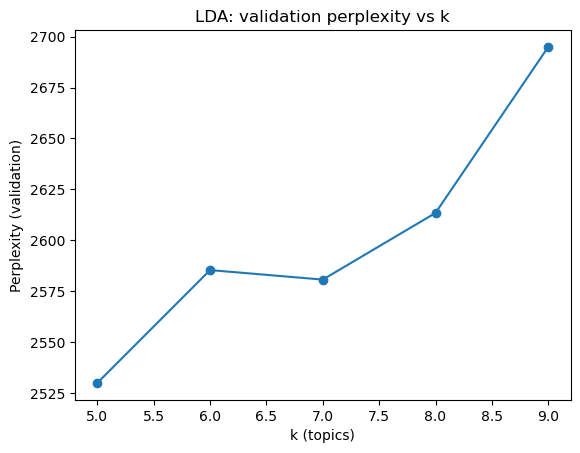

In [17]:
plt.plot(metrics_df["k"], metrics_df["perplexity_valid"], marker="o")
plt.xlabel("k (topics)")
plt.ylabel("Perplexity (validation)")
plt.title("LDA: validation perplexity vs k")
plt.show()

Check top words to manually evaluate best interpretability

In [18]:
for k in candidate_topics:
    print_top_words(lda_models[k], vocab, n_top=12, title=f"\n=== k={k} ===")


=== k=5 ===
Topic 00: service | card | features | customer | exchange | customer service | rates | abroad | currency | free | fees | travel
Topic 01: update | user | friendly | user friendly | pay | log | phone | security | android | crashes | payment | contactless
Topic 02: problems | navigate | transactions | balance | version | feature | transaction | log | fingerprint | login | functionality | previous
Topic 03: money | transfer | secure | payments | check | manage | transfer money | pay | track | send | bills | transfers
Topic 04: phone | access | support | help | chat | issue | problem | details | screen | code | contact | security


=== k=6 ===
Topic 00: service | card | exchange | customer | customer service | features | rates | abroad | currency | free | fees | travel
Topic 01: update | user | friendly | user friendly | pay | log | phone | android | crashes | updated | contactless | crashing
Topic 02: problems | navigate | payment | transfers | login | fingerprint | balance |

**✅ RUN SELECTED MODEL AND SAVE RESULTS**

When we analyse the key words for each `k` for the number of topics it is clear that lower number of topics generate more coherent topics than when we use higher `k`. Given the validation perplexity scores and their interpretation, we selct **7 topics as the optimal choice** for the best LDA.

In [19]:
chosen_k = 7

# Train model with selected parameters
lda_best = fit_lda(X, n_topics=chosen_k)

LDA fit done: 7 topics in 621.1s


In [20]:
# print topics for k=7
print_top_words(lda_best, vocab, n_top=12)

Topic 00: service | customer | exchange | card | customer service | rates | abroad | currency | free | features | fees | travel
Topic 01: update | log | phone | pay | android | crashes | updated | contactless | error | load | crashing | security
Topic 02: problems | navigate | transfers | fingerprint | balance | login | version | functionality | feature | issue | design | payments
Topic 03: money | transfer | secure | check | pay | manage | transfer money | send | bills | track | payments | balance
Topic 04: phone | support | help | chat | details | access | contact | code | problem | screen | password | issue
Topic 05: transactions | payments | problem | intuitive | features | control | direct | view | finger | updates | standing | layout
Topic 06: card | user | friendly | user friendly | payment | credit | cards | interface | access | credit card | transaction | options



In [21]:
# Save
joblib.dump(lda_best, "../assets/lda_final_ALL.pkl")
joblib.dump(vectorizer, "../assets/vectorizer_final_ALL.pkl")
print("✅ Files saved")

✅ Files saved


### 4.1.3. - LDA trained with NEGATIVE reviews only

Let's now **train a LDA model exclusively on reviews with negative sentiment** so that we can **extract more meaningfull insights** regarding **pain points** on each app.

In [22]:
df_neg = df_model[df_model['review_sentiment_label'] == 'negative'].copy()

print(f"df_model shape: {df_model.shape}")
print(f"df_neg shape: {df_neg.shape}")

df_model shape: (429456, 21)
df_neg shape: (58915, 21)


**I. INITIAL RUN OF LDA WITH 10 TOPICS**

In [23]:
vectorizer_neg = build_vectorizer(stop_words)
X_neg = vectorizer_neg.fit_transform(df_neg['review_extra_clean'])
vocab_neg = vectorizer_neg.get_feature_names_out()

lda_neg_10 = fit_lda(X_neg, n_topics=10)
print_top_words(lda_neg_10, vocab, n_top=12, title ="Top words @ 10 topics")

LDA fit done: 10 topics in 109.5s
Top words @ 10 topics
Topic 00: access transfer | farce | fees card | disgrace | dissatisfied | currencies travel | council tax | card metal | barcleys | costing | expiring | assets
Topic 01: download install | backgrounds | backs | copies | aplikacja | attempts | council tax | crash | countries currency | advert | card today | charge
Topic 02: farce | crash | currency payments | bloody | disabling | features coming | commissions | big update | fintech company | deleted | fails load | classic
Topic 03: errors | copies | advising | complain | appears | expiring | expiry | adopt | aint broke | encounter | encanta | card paid
Topic 04: classic | convinced | considering | available samsung | chosen | apt | captured | access transfer | disgrace | create virtual | click button | enter pin
Topic 05: access personal | farce | crash | basic card | bugs fixed | click button | direct feature | basic functionality | features exchange | crashing login | avoid avoid

**II. Finetune stopwords and re-run LDA**

In [24]:
neg_extra = {
    'abd','abit','according','address','anoying','annoying','approximately','appit',
    'applies','arbitrary','arise','aspects','awful','awhile','awkward','bare','bardzo',
    'barclaycard','based','basis','banki','began','begin','believe','barely',
    'bloody','boys','buys','centres','consider','constantly','continue','continually',
    'contrary','cool','corporate','cos','couple','covered','damn','dave','dear',
    'decades','dedicated','depend','der','des','difficult','die','dinosaur',
    'dirty','dislike','dosnt','email','exist','faced','fairly','firstly','fix',
    'frustrating','fyi','goto','half','hanging','hate','heavy','heard', 'infuriating',
    'minutes','poor','saying','waste','hello','worse','wouldnt'
}

stop_words_neg = list(set(stop_words).union(neg_extra))

In [25]:
vectorizer_neg = build_vectorizer(stop_words_neg, ngram_range=(1,2), min_df=25, max_df=0.6)
X_neg = vectorizer_neg.fit_transform(df_neg['review_extra_clean'])
vocab_neg = vectorizer_neg.get_feature_names_out()

In [26]:
tmp_vec = CountVectorizer(
    preprocessor=lambda x: x,
    token_pattern=r'(?u)\b[a-z<][a-z<>-]{2,}\b',
    stop_words=stop_words_neg,
    ngram_range=(1,1)
)
analyze = tmp_vec.build_analyzer()

min_tokens_after_sw = 1
mask = df_neg['review_extra_clean'].map(lambda s: len(analyze(s)) >= min_tokens_after_sw)
print("Dropped after SW-length filter:", int((~mask).sum()))
df_neg = df_neg[mask].copy()

Dropped after SW-length filter: 342


**III. Test different `n_topics` and evaluate results**

In [27]:
Xtr, Xva = train_test_split(X_neg, test_size=0.2, random_state=42)

In [28]:
candidate_negtopics = [4,5,6,7,8]
lda_models, rows = {}, []

for k in candidate_negtopics:
    model = fit_lda(Xtr, k)
    lda_models[k]=model
    rows.append({
        "k": k,
        "perplexity_train": model.perplexity(Xtr),  # lower = better
        "perplexity_valid": model.perplexity(Xva),  # lower = better
        "elbo_train": model.score(Xtr),             # higher = better
        "elbo_valid": model.score(Xva)              # higher = better
    })

neg_metrics_df = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
display(neg_metrics_df)

LDA fit done: 4 topics in 98.8s
LDA fit done: 5 topics in 93.8s
LDA fit done: 6 topics in 92.1s
LDA fit done: 7 topics in 89.5s
LDA fit done: 8 topics in 86.5s


,k,perplexity_train,perplexity_valid,elbo_train,elbo_valid
0,4,1208.547933,1464.296445,-2.675245e+06,-691607.248207
1,5,1222.242746,1532.968721,-2.679492e+06,-695955.814640
2,6,1235.813579,1597.398345,-2.683654e+06,-699862.113785
3,7,1250.305954,1664.827782,-2.688049e+06,-703785.049180
4,8,1238.601040,1691.338722,-2.684503e+06,-705284.059056


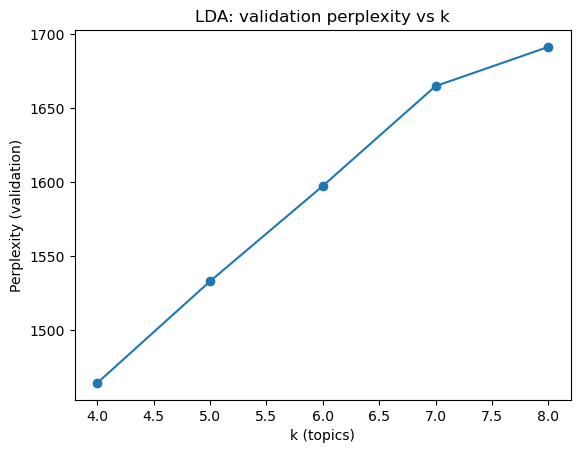

In [29]:
plt.plot(neg_metrics_df["k"], neg_metrics_df["perplexity_valid"], marker="o")
plt.xlabel("k (topics)")
plt.ylabel("Perplexity (validation)")
plt.title("LDA: validation perplexity vs k")
plt.show()

In [30]:
for k in candidate_negtopics:
    print_top_words(lda_models[k], vocab_neg, n_top=12, title=f"\n=== k={k} ===")


=== k=4 ===
Topic 00: phone | update | log | access | login | code | android | screen | problem | updated | version | crashes
Topic 01: pay | card | payments | payment | contactless | user | transactions | paying | lost | update | option | features
Topic 02: error | update | balance | message | problem | problems | notifications | issue | direct | check | download | available
Topic 03: money | service | customer | transfer | card | customer service | support | chat | help | contact | blocked | access


=== k=5 ===
Topic 00: phone | log | update | access | code | login | password | fingerprint | details | device | security | updated
Topic 01: pay | card | payments | payment | contactless | lost | paying | transactions | credit | feature | cards | photo
Topic 02: update | error | screen | balance | message | notifications | problems | log | transactions | check | problem | direct
Topic 03: money | service | customer | transfer | customer service | chat | support | card | help | contact 

**✅ RUN SELECTED MODEL AND SAVE RESULTS**

In [31]:
chosen_k_neg = 6

lda_best_neg = fit_lda(X_neg, n_topics=chosen_k_neg)

print_top_words(lda_best_neg, vocab_neg, 12)

LDA fit done: 6 topics in 115.2s
Topic 00: phone | log | update | access | code | login | password | fingerprint | updated | device | security | details
Topic 01: pay | payments | card | payment | contactless | problems | lost | paying | transactions | feature | credit | crashing
Topic 02: update | error | screen | message | balance | notifications | log | page | download | direct | problem | transactions
Topic 03: money | transfer | blocked | access | transfer money | help | funds | fraud | transaction | send | payment | block
Topic 04: version | problem | user | update | android | fees | pay | previous | upgrade | crypto | exchange | confusing
Topic 05: service | customer | card | customer service | support | chat | hours | contact | help | verify | verification | issue



In [32]:
# Save
joblib.dump(lda_best_neg, "../assets/lda_final_NEG.pkl")
joblib.dump(vectorizer_neg, "../assets/vectorizer_final_NEG.pkl")
print("✅ Files saved")

✅ Files saved


### 4.1.4. - LDA trained with POSITIVE reviews only

Finally we'll **train a LDA model exclusively on reviews with positive sentiment** so that we can **extract more meaningfull insights** regarding **strenghts** on each app.

In [33]:
df_pos = df_model[df_model['review_sentiment_label'] == 'positive'].copy()

print(f"df_model shape: {df_model.shape}")
print(f"df_neg shape: {df_pos.shape}")

df_model shape: (429456, 21)
df_neg shape: (309006, 21)


**I. INITIAL RUN OF LDA WITH 10 TOPICS**

In [34]:
vectorizer_pos = build_vectorizer(stop_words)
X_pos = vectorizer_pos.fit_transform(df_pos['review_extra_clean'])
vocab_pos = vectorizer_pos.get_feature_names_out()

lda_pos_10 = fit_lda(X_pos, n_topics=10)
print_top_words(lda_pos_10, vocab_pos, n_top=12, title ="Top words @ 10 topics")

LDA fit done: 10 topics in 399.2s
Top words @ 10 topics
Topic 00: abroad | balance | money | free | currency | transferring | check | spending | feel | transferring money | fees | check balance
Topic 01: problem | services | intuitive | paying | crypto | save | credit | cool | saving | layout | financial | credit card
Topic 02: card | money | manage | transactions | rate | exchange | check | send | cards | currencies | send money | payments
Topic 03: transfer | money | access | rates | transfer money | track | transfers | exchange | exchange rates | help | friends | family
Topic 04: features | options | cash | managing | transactions | card | travelling | world | tool | notifications | site | wouldnt
Topic 05: update | phone | log | payment | screen | android | updated | version | crashes | payee | contactless | load
Topic 06: service | secure | navigate | customer | customer service | direct | interface | functionality | complaints | debits | direct debits | clean
Topic 07: support | 

**II. Finetune stopwords and re-run LDA**

In [35]:
pos_extra = {'lovely'} #

stop_words_pos = list(set(stop_words).union(pos_extra))

In [36]:
vectorizer_pos = build_vectorizer(stop_words_pos, ngram_range=(1,2), min_df=25, max_df=0.6)
X_pos = vectorizer_pos.fit_transform(df_pos['review_extra_clean'])
vocab_pos = vectorizer_pos.get_feature_names_out()

In [37]:
tmp_vec = CountVectorizer(
    preprocessor=lambda x: x,
    token_pattern=r'(?u)\b[a-z<][a-z<>-]{2,}\b',
    stop_words=stop_words_pos,
    ngram_range=(1,1)
)
analyze = tmp_vec.build_analyzer()

min_tokens_after_sw = 1
mask = df_pos['review_extra_clean'].map(lambda s: len(analyze(s)) >= min_tokens_after_sw)
print("Dropped after SW-length filter:", int((~mask).sum()))
df_pos = df_pos[mask].copy()

Dropped after SW-length filter: 475


**III. Test different `n_topics` and evaluate results**

In [38]:
Xtr, Xva = train_test_split(X_pos, test_size=0.2, random_state=42)

In [39]:
candidate_postopics = [4,5,6,7,8]
lda_models, rows = {}, []

for k in candidate_postopics:
    model = fit_lda(Xtr, k)
    lda_models[k]=model
    rows.append({
        "k": k,
        "perplexity_train": model.perplexity(Xtr),  # lower = better
        "perplexity_valid": model.perplexity(Xva),  # lower = better
        "elbo_train": model.score(Xtr),             # higher = better
        "elbo_valid": model.score(Xva)              # higher = better
    })

pos_metrics_df = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
display(pos_metrics_df)

LDA fit done: 4 topics in 368.6s
LDA fit done: 5 topics in 343.2s
LDA fit done: 6 topics in 331.5s
LDA fit done: 7 topics in 321.7s
LDA fit done: 8 topics in 317.8s


,k,perplexity_train,perplexity_valid,elbo_train,elbo_valid
0,4,1474.858983,1687.333089,-7.821864e+06,-1.992025e+06
1,5,1447.007410,1680.350932,-7.801426e+06,-1.990913e+06
2,6,1428.781425,1683.812163,-7.787837e+06,-1.991465e+06
3,7,1424.883879,1703.052515,-7.784909e+06,-1.994511e+06
4,8,1430.764679,1735.663159,-7.789324e+06,-1.999595e+06


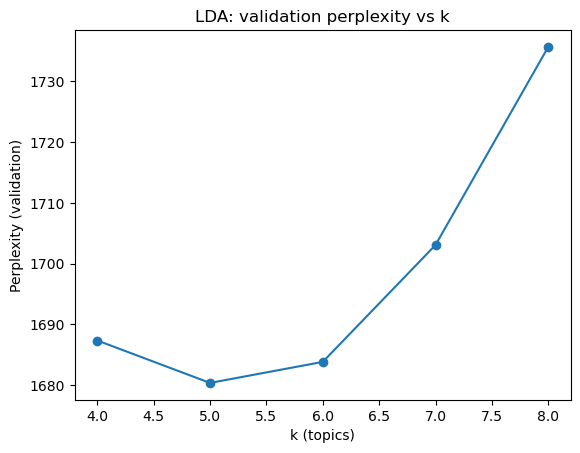

In [40]:
plt.plot(pos_metrics_df["k"], pos_metrics_df["perplexity_valid"], marker="o")
plt.xlabel("k (topics)")
plt.ylabel("Perplexity (validation)")
plt.title("LDA: validation perplexity vs k")
plt.show()

In [41]:
for k in candidate_postopics:
    print_top_words(lda_models[k], vocab_pos, n_top=12, title=f"\n=== k={k} ===")


=== k=4 ===
Topic 00: service | card | user | friendly | user friendly | navigate | exchange | rates | abroad | currency | travel | credit
Topic 01: features | security | problem | transactions | manage | log | control | update | payment | fingerprint | login | screen
Topic 02: money | secure | transfer | payments | check | pay | transfers | access | transfer money | balance | track | spending
Topic 03: problems | phone | update | customer | support | services | free | help | pay | issue | customer service | crypto


=== k=5 ===
Topic 00: service | user | friendly | user friendly | navigate | customer | customer service | manage | fault | internet | financial | travelling
Topic 01: features | security | problem | transactions | log | fingerprint | control | login | manage | screen | payment | update
Topic 02: money | transfer | check | access | balance | pay | transfer money | payments | track | spending | bills | options
Topic 03: problems | phone | update | support | help | services

**✅ RUN SELECTED MODEL AND SAVE RESULTS**

In [42]:
chosen_k_pos = 6

lda_best_pos = fit_lda(X_pos, n_topics=chosen_k_pos)

print_top_words(lda_best_pos, vocab_pos, 12)

LDA fit done: 6 topics in 423.7s
Topic 00: service | user | friendly | user friendly | navigate | customer | customer service | fault | security | internet | faster | responsive
Topic 01: features | transactions | manage | security | problem | control | log | feature | feel | fingerprint | payee | option
Topic 02: money | secure | transfer | check | transfer money | balance | payments | track | pay | spending | bills | transferring
Topic 03: problems | services | pay | crypto | free | high | transaction | customer | trading | customers | staff | stocks
Topic 04: card | money | exchange | payments | abroad | rates | transfers | currency | travel | rate | credit | friends
Topic 05: phone | update | help | access | support | issue | log | version | updated | android | information | chat



In [43]:
# Save
joblib.dump(lda_best_pos, "../assets/lda_final_POS.pkl")
joblib.dump(vectorizer_pos, "../assets/vectorizer_final_POS.pkl")
print("✅ Files saved")

✅ Files saved


## 4.2. - Model Deployment

In section 4.1., three LDA models were trained: i) lda_ALL trained on all type of reviews; 2) lda_NEG trained on negative reviews only; 3) lda_POS trained on positive reviews only. Now we will transform the original dataframe we had at the beggining of this notebook using the 3 selected LDAs and assigning the corresponding topic labels for each review and model. All the transformations are encapsulated inside `apply_ldas` to facilitate reproducibility.

In [3]:
def apply_ldas(
    df: pd.DataFrame,
    text_col: str = "review_text_clean",
    # generic model (trained on all reviews)
    lda_path: str = "../assets/lda_final_ALL.pkl",
    vect_path: str = "../assets/vectorizer_final_ALL.pkl",
    # negative-only model
    lda_neg_path: str = "../assets/lda_final_NEG.pkl",
    vect_neg_path: str = "../assets/vectorizer_final_NEG.pkl",
    # positive-only model
    lda_pos_path: str = "../assets/lda_final_POS.pkl",
    vect_pos_path: str = "../assets/vectorizer_final_POS.pkl",
    inplace: bool = True,
) -> pd.DataFrame:
    """
    Append 9 columns using three LDA models:
      Generic: topic_id_ALL, topic_label_ALL, topic_prob_ALL
      Negative-only (score in {1,2}): topic_id_NEG, topic_label_NEG, topic_prob_NEG
      Positive-only (score in {4,5}): topic_id_POS, topic_label_POS, topic_prob_POS
    """
    if not inplace:
        df = df.copy()

    print(f"Initial shape of the dataframe: {df.shape}")

    # --- Text cleaning ----------------------------------------------------
    def text_cleaner(x):
        if not isinstance(x, str):
            return pd.NA
        t = x
        t = re.sub(r"@\w+", " ", t)                  # remove @mentions
        t = re.sub(r"\d+", " <num> ", t)             # numbers -> <num>
        t = re.sub(r"[^a-z\s<>]+", " ", t)           # keep letters, spaces, and <> so <num> survives
        t = re.sub(r"\s+", " ", t).strip()           # normalize whitespace
        return t if t else pd.NA

    df["review_extra_clean"] = df[text_col].map(text_cleaner)   

    if text_col not in df.columns:
        raise KeyError(f"Column '{text_col}' not found.")

    s = df[text_col].astype("string")  # NA-safe string Series

    # ----------------- helper -----------------
    def _apply_one(lda, vect, mask_rows, label_map, col_suffix, nan_outside_mask: bool):
        """
        lda, vect: fitted artifacts
        mask_rows: boolean mask of rows to consider for this model
        label_map: dict[int,str] mapping topic id -> label
        col_suffix: '_ALL', '_NEG', or '_POS'
        nan_outside_mask:
            - True  -> rows outside mask get NaN in all 3 columns (for neg/pos models)
            - False -> rows outside eligibility get Undefined/-1/0.0 (for generic model)
        """
        if not hasattr(vect, "transform"):
            raise TypeError("Loaded vectorizer has no .transform()")

        # Eligibility rules
        analyzer = vect.build_analyzer()
        
        sw_ok = s.fillna("").map(lambda t: len(analyzer(t)) >= 1)
        consistent_ok = df["Consistent"].fillna(0).astype(int).eq(1)

        elig = mask_rows & sw_ok & consistent_ok

        # Prepare outputs
        if nan_outside_mask:
            # For neg/pos models we keep NaN outside the score mask
            topic_id = pd.Series(np.nan, index=df.index, dtype="float")
            topic_prob = pd.Series(np.nan, index=df.index, dtype="float")
            topic_label = pd.Series(np.nan, index=df.index, dtype="string")
        else:
            # For generic model, fill with Undefined defaults when ineligible
            topic_id = pd.Series(-1, index=df.index, dtype="int64")
            topic_prob = pd.Series(0.0, index=df.index, dtype="float64")
            topic_label = pd.Series("Undefined", index=df.index, dtype="string")

        # Vectorize eligible subset
        if elig.any():
            X = vect.transform(s[elig].fillna(""))

            # Rule 3: drop zero-feature rows (OOV)
            zero = np.array(X.sum(axis=1)).ravel() == 0
            if zero.any():
                bad_idx = s[elig].index[zero]
                elig.loc[bad_idx] = False
                if elig.any():
                    X = vect.transform(s[elig].fillna(""))

            # Score eligible
            if elig.any():
                D = lda.transform(X)                       # (n_docs_elig, n_topics)
                ti = D.argmax(axis=1)
                tp = D.max(axis=1)

                topic_id.loc[elig] = ti
                topic_prob.loc[elig] = tp
                topic_label.loc[elig] = pd.Series(ti, index=df[elig].index).map(
                    lambda k: label_map.get(int(k), "Undefined")
                ).astype("string")

        # Attach to df
        df[f"topic_id{col_suffix}"] = topic_id
        df[f"topic_label{col_suffix}"] = topic_label
        df[f"topic_prob{col_suffix}"] = topic_prob

    # ----------------- load artifacts -----------------
    lda_all = joblib.load(lda_path)
    vect_all = joblib.load(vect_path)
    lda_neg = joblib.load(lda_neg_path)
    vect_neg = joblib.load(vect_neg_path)
    lda_pos = joblib.load(lda_pos_path)
    vect_pos = joblib.load(vect_pos_path)

    # ----------------- label maps (edit to your final names) -----------------
    labels_gen = {
        0: "Fees & Service & Travel",
        1: "Updates, Crashes & Performance",
        2: "Login, Navigation & Functionality Issues",
        3: "Money Transfers & Payment Management",
        4: "Support & Access",
        5: "Transactions, Features & Usability",
        6: "Cards & Payments",
    } 
    labels_neg = {
        0: "Login & Security",
        1: "Payments & Cards",
        2: "Updates & Crashes",
        3: "Transfers & Transact",
        4: "Interface & Fees",
        5: "Customer Support",
    }
    # Stub/default for positive model – adjust to your pos-only training labels
    labels_pos = {
        0: "Usability",
        1: "Features & Security",
        2: "Transactions & Money Mgmt",
        3: "Investments",
        4: "Cards & Travel",
        5: "Updates & Support",
    }

    # ----------------- run all three -----------------
    # Generic: run for everyone; ineligible -> Undefined/-1/0.0
    _apply_one(lda_all, vect_all, mask_rows=pd.Series(True, index=df.index), label_map=labels_gen,
               col_suffix="_ALL", nan_outside_mask=False)

    # Negative-only: only when score ∈ {1,2}; outside mask stays NaN
    _apply_one(lda_neg, vect_neg, mask_rows=df["score"].isin([1, 2]), label_map=labels_neg,
               col_suffix="_NEG", nan_outside_mask=True)

    # Positive-only: only when score ∈ {4,5}; outside mask stays NaN
    _apply_one(lda_pos, vect_pos, mask_rows=df["score"].isin([4, 5]), label_map=labels_pos,
               col_suffix="_POS", nan_outside_mask=True)

    # Order columns: keep original order, then append all new columns
    tail = [
        "topic_id_ALL", "topic_label_ALL", "topic_prob_ALL",
        "topic_id_NEG", "topic_label_NEG", "topic_prob_NEG",
        "topic_id_POS", "topic_label_POS", "topic_prob_POS",
    ]
    base = [c for c in df.columns if c not in tail]
    df = df[base + tail]

    # Final cleaning droping unnecessary columns
    df = df.drop(columns=["year", "review_extra_clean", "review_text_clean","reply_text_clean"])

    print(f"Final shape of the dataframe: {df.shape}")

    # --- Save Final Dataframe ---
    save_path = "../assets/df_final.parquet"
    df.to_parquet(save_path, index = False)
    print(f"✅ Dataframe saved in {save_path}")

    return df

In [4]:
df_final = apply_ldas (df_sentiment)

Initial shape of the dataframe: (703563, 20)
Final shape of the dataframe: (703563, 26)
✅ Dataframe saved in ../assets/df_final.parquet


In [5]:
pd.set_option("display.max_columns", None)
df_final.head(10)

,review_id,app,score,review_text,review_date,thumbs_up,replied,reply_text,reply_date,time_to_reply(h),app_version_head,app_version_detail,review_sentiment,review_sentiment_label,Consistent,reply_sentiment,reply_sentiment_label,topic_id_ALL,topic_label_ALL,topic_prob_ALL,topic_id_NEG,topic_label_NEG,topic_prob_NEG,topic_id_POS,topic_label_POS,topic_prob_POS
0,1,Santander,5,"very easy to use app, very happy with it",2025-09-04 14:21:00,0,1,"Hi! Thanks for the 5* review, we're so glad to...",2025-09-04 14:40:12,0.32,5,24.0,0.8012,positive,1,0.8767,positive,-1,Undefined,0.000000,NaN,<NA>,NaN,NaN,<NA>,NaN
1,2,Santander,3,New 2024 app is slow to open. Too much whitesp...,2025-09-04 13:36:26,3,1,Hey there! All feedback is greatly appreciated...,2024-04-29 14:16:29,-11831.33,5,24.0,-0.9020,negative,1,0.8930,positive,5,"Transactions, Features & Usability",0.601978,NaN,<NA>,NaN,NaN,<NA>,NaN
2,3,Santander,5,easy to use.. Great..,2025-09-04 13:27:27,0,1,"Hello Karen, thanks for the great feedback and...",2025-09-04 13:32:12,0.08,5,24.0,0.7906,positive,1,0.9100,positive,-1,Undefined,0.000000,NaN,<NA>,NaN,NaN,<NA>,NaN
3,4,Santander,2,having issues with your updates .. advice,2025-09-04 13:26:24,0,1,We would need a bit more information about the...,2025-09-04 13:36:37,0.17,5,22.0,0.0000,neutral,1,0.4588,positive,5,"Transactions, Features & Usability",0.713743,1.0,Payments & Cards,0.719216,NaN,<NA>,NaN
4,5,Santander,5,so easy to use,2025-09-04 12:37:14,0,1,Many thanks for your 5 star review.\n^ES ^ES,2025-09-04 12:47:38,0.17,5,24.0,0.4927,positive,1,0.4404,positive,-1,Undefined,0.000000,NaN,<NA>,NaN,NaN,<NA>,NaN
5,6,Santander,5,Easy.,2025-09-04 10:25:54,0,1,Hello. Thanks for leaving a great review. Have...,2025-09-04 10:45:41,0.33,5,24.0,0.4404,positive,1,0.8777,positive,-1,Undefined,0.000000,NaN,<NA>,NaN,NaN,<NA>,NaN
6,7,Santander,3,it would be a lot better if the balance widget...,2025-09-04 09:19:42,0,1,Hey there! Thanks for sharing. All feedback is...,2025-09-04 10:00:10,0.67,5,25.0,0.6249,positive,1,0.8976,positive,2,"Login, Navigation & Functionality Issues",0.660740,NaN,<NA>,NaN,NaN,<NA>,NaN
7,8,Santander,3,Having changed a savings account name (which w...,2025-09-04 09:19:39,0,1,Hi there! We're sorry to hear this. We'll need...,2025-09-04 08:59:15,-0.34,5,24.0,-0.6661,negative,1,0.3164,positive,1,"Updates, Crashes & Performance",0.373506,NaN,<NA>,NaN,NaN,<NA>,NaN
8,9,Santander,4,They put the widget back! All is right with th...,2025-09-04 09:08:17,0,1,"Hi there, this is what we like to hear! Thank ...",2025-09-04 09:57:35,0.82,5,24.0,0.9396,positive,1,0.9245,positive,2,"Login, Navigation & Functionality Issues",0.933764,NaN,<NA>,NaN,1.0,Features & Security,0.929608
9,10,Santander,5,Easy to use,2025-09-04 08:59:20,0,1,Hi there! Thanks for leaving such lovely comme...,2025-09-04 09:03:17,0.07,5,24.0,0.4404,positive,1,0.8748,positive,-1,Undefined,0.000000,NaN,<NA>,NaN,NaN,<NA>,NaN


## 4.3. - Analysis of the Results

### 4.3.1. - All reviews model

1️⃣ **Coherence sanity check** by evaluating a sample of reviews / labels

In [6]:
def sample_reviews_by_topic(
    df,
    n: int = 5,
    seed: int = 40,
    topic_col: str = "topic_id_ALL",
    label_col: str = "topic_label_ALL",
    prob_col: str = "topic_prob_ALL",
    text_col: str = "review_text",
    score_col: str = "score",
    sentiment_col: str = "review_sentiment_label",
):
    """
    For each topic, sample up to n rows and return a small table with:
      topic_id, topic_label, sample_text, score (if present), sentiment (if present)
    """
    if topic_col not in df.columns:
        raise KeyError(f"Missing column: {topic_col}")
    if text_col not in df.columns:
        raise KeyError(f"Missing column: {text_col}")

    rows = []
    for tid, g in df.dropna(subset=[topic_col]).groupby(topic_col):
        label = g[label_col].iloc[0] if label_col in g.columns else f"Topic {tid}"
        take = min(n, len(g))
        samp = g.sample(take, random_state=seed + int(tid))[[prob_col] + [text_col] + ([score_col] if score_col in g.columns else []) + ([sentiment_col] if sentiment_col in g.columns else [])]

        for idx, r in samp.iterrows():
            rec = {
                "topic_id": tid,
                "topic_label": label,
                "topic_prob": (r[prob_col] if prob_col in samp.columns else None),
                "sample_text": r[text_col],
            }
            if score_col in samp.columns:
                rec["score"] = r[score_col]
            if sentiment_col in samp.columns:
                rec["sentiment"] = r[sentiment_col]
            rows.append(rec)

    out = pd.DataFrame(rows).sort_values(["topic_id"]).reset_index(drop=True)
    return out

In [7]:
samples_df = sample_reviews_by_topic(df_final, topic_col= "topic_id_ALL",label_col= "topic_label_ALL", prob_col = "topic_prob_ALL", n=5, seed=40)
with pd.option_context('display.max_colwidth', None, 'display.width', None):
    display(samples_df)

,topic_id,topic_label,topic_prob,sample_text,score,sentiment
0,-1,Undefined,0.000000,Sweeeeeeet app,5,neutral
1,-1,Undefined,0.000000,"""we detected some suspicious activity"" when you actually need it it will ask for a verification on your little boy's size in inches, and a chat takes a month to solve",1,negative
2,-1,Undefined,0.000000,Fast,5,neutral
3,-1,Undefined,0.000000,Revolut has made life mush more easy,5,positive
4,-1,Undefined,0.000000,Excellent,5,positive
5,0,Fees & Service & Travel,0.571429,Exceptional!,5,neutral
6,0,Fees & Service & Travel,0.571429,Best service ever.,5,positive
7,0,Fees & Service & Travel,0.571429,great rates and great app,5,positive
8,0,Fees & Service & Travel,0.413686,All good. No problems Security excellent.,5,positive
9,0,Fees & Service & Travel,0.904543,"The app was good, but Revolut keeps changing it! I'm all for new features, but this is becoming ridiculous. I can no longer find tools I used to use such as the currency conversion tool.",1,negative


2️⃣ **Topic distribution per type of sentiment**

In [8]:
df_final.head(2)

,review_id,app,score,review_text,review_date,thumbs_up,replied,reply_text,reply_date,time_to_reply(h),app_version_head,app_version_detail,review_sentiment,review_sentiment_label,Consistent,reply_sentiment,reply_sentiment_label,topic_id_ALL,topic_label_ALL,topic_prob_ALL,topic_id_NEG,topic_label_NEG,topic_prob_NEG,topic_id_POS,topic_label_POS,topic_prob_POS
0,1,Santander,5,"very easy to use app, very happy with it",2025-09-04 14:21:00,0,1,"Hi! Thanks for the 5* review, we're so glad to...",2025-09-04 14:40:12,0.32,5,24.0,0.8012,positive,1,0.8767,positive,-1,Undefined,0.000000,NaN,<NA>,NaN,NaN,<NA>,NaN
1,2,Santander,3,New 2024 app is slow to open. Too much whitesp...,2025-09-04 13:36:26,3,1,Hey there! All feedback is greatly appreciated...,2024-04-29 14:16:29,-11831.33,5,24.0,-0.9020,negative,1,0.8930,positive,5,"Transactions, Features & Usability",0.601978,NaN,<NA>,NaN,NaN,<NA>,NaN


In [9]:
topic_sent = (df_final.groupby(["topic_id_ALL","topic_label_ALL","review_sentiment_label"], observed=True)
                        .size().unstack(fill_value=0))

topic_sent["total"] = topic_sent.get("negative", 0) + topic_sent.get("neutral", 0) + topic_sent.get("positive", 0)
topic_sent["share_neg"] = topic_sent.get("negative", 0) / topic_sent[["negative","neutral","positive"]].sum(axis=1).replace(0, np.nan)
topic_sent["share_pos"] = topic_sent.get("positive", 0) / topic_sent[["negative","neutral","positive"]].sum(axis=1).replace(0, np.nan)
topic_sent = topic_sent.sort_values(by="topic_id_ALL", ascending=True)

display(topic_sent)

,review_sentiment_label,negative,neutral,positive,undefined,total,share_neg,share_pos
topic_id_ALL,topic_label_ALL,,,,,,,
-1,Undefined,22452,37719,285790,70,345961,0.064897,0.826076
0,Fees & Service & Travel,3787,7974,58526,0,70287,0.053879,0.832672
1,"Updates, Crashes & Performance",13792,10323,21375,0,45490,0.303188,0.469883
2,"Login, Navigation & Functionality Issues",4338,6916,35143,0,46397,0.093497,0.757441
3,Money Transfers & Payment Management,2825,4398,44863,0,52086,0.054237,0.861326
4,Support & Access,17481,9114,30159,0,56754,0.308014,0.531399
5,"Transactions, Features & Usability",4287,6692,36750,0,47729,0.089820,0.769972
6,Cards & Payments,3125,3737,31927,0,38789,0.080564,0.823094


3️⃣ **Topic distribution per app and scores**

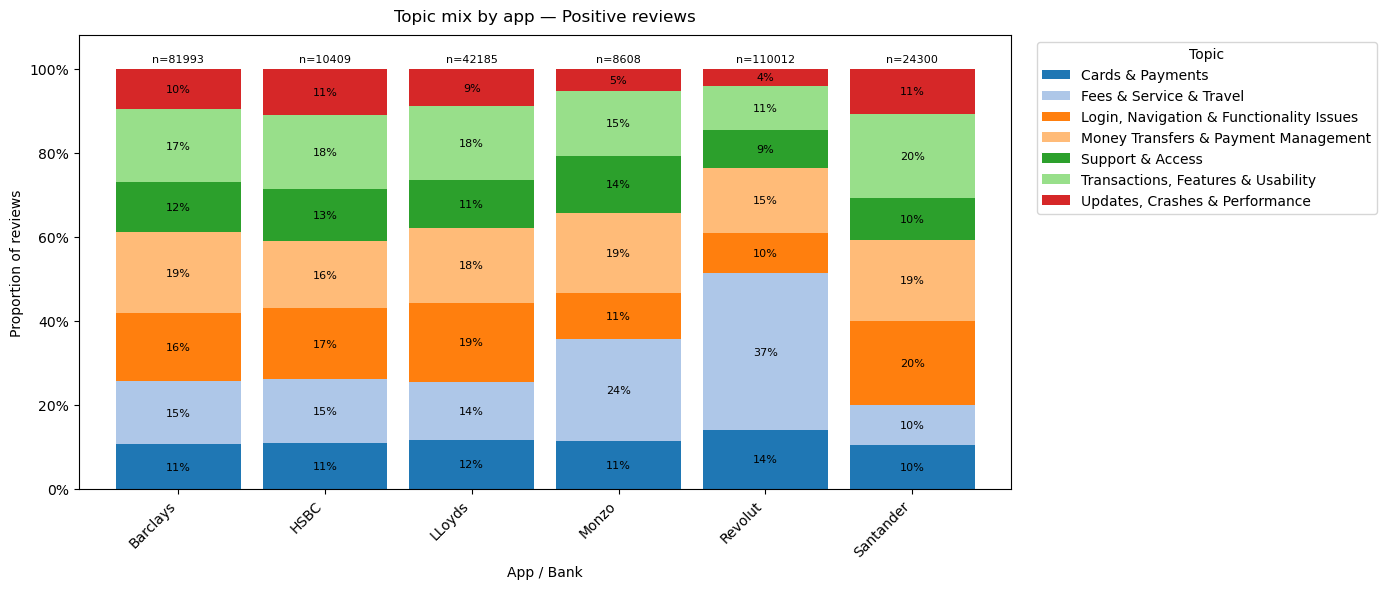

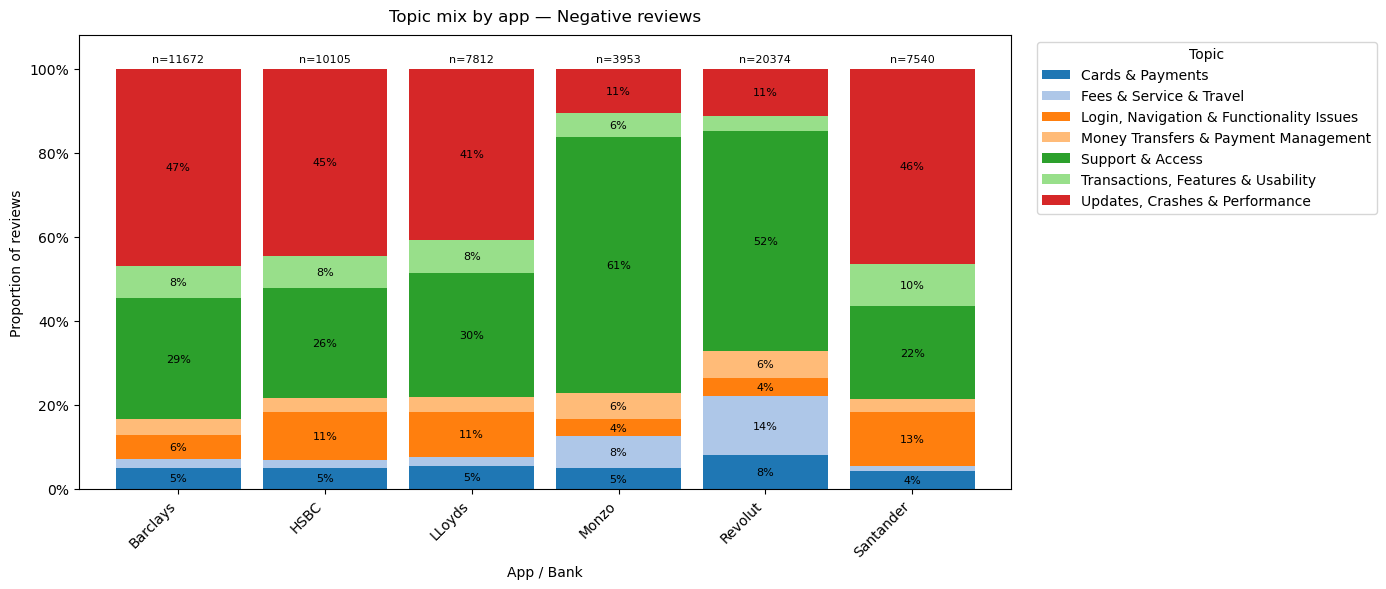

In [10]:
# Keep only rows where topic_label_ALL is not 'Undefined'
df_sub = df_final[df_final["topic_label_ALL"] != "Undefined"].copy()

# define topics, apps and colors
topics = sorted(df_sub['topic_label_ALL'].dropna().unique())
apps   = sorted(df_sub['app'].dropna().unique())

palette = plt.get_cmap('tab20').colors
topic_color = {t: palette[i % len(palette)] for i, t in enumerate(topics)}

def topic_share_by_app(df, score, label_col= 'topic_label_ALL', min_reviews=0):
    tmp = (df[df['score'].isin(score)]
             .dropna(subset=[label_col,'app'])
             .groupby(['app',label_col])
             .size()
             .unstack(fill_value=0))
    tmp = tmp.reindex(index=apps, columns=topics, fill_value=0)

    totals = tmp.sum(axis=1)
    if min_reviews > 0:
        tmp = tmp.loc[totals >= min_reviews]
        totals = tmp.sum(axis=1)

    shares = tmp.div(totals.replace(0, np.nan), axis=0).fillna(0)
    return shares, totals

def plot_stacked(shares, totals, title, label_threshold=0.04):
    ax = shares.plot(
        kind='bar', stacked=True, figsize=(14,6), width=0.85,
        color=[topic_color[t] for t in shares.columns]
    )
    ax.set_title(title)
    ax.set_xlabel('App / Bank')
    ax.set_ylabel('Proportion of reviews')
    ax.set_ylim(0, 1.08)
    ax.set_title(title, pad=10)  
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
    ax.legend(title='Topic', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # --- % labels inside segments ---
    for i, (_, row) in enumerate(shares.iterrows()):
        cum = 0.0
        for t in shares.columns:
            v = float(row[t])
            if v > 0:
                if v >= label_threshold:  # avoid clutter for tiny slices
                    ax.text(
                        i, cum + v/2, f"{v:.0%}",
                        ha='center', va='center',
                        fontsize=8,
                        color='black'
                    )
                cum += v

    # --- show n on top of each bar ---
    for i, n in enumerate(totals.loc[shares.index]):
        ax.text(i, 1.01, f"n={int(n)}", ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# --- build data & plot ---
pos_shares, pos_totals = topic_share_by_app(df_sub, score = [4,5], label_col= 'topic_label_ALL', min_reviews=0)
neg_shares, neg_totals = topic_share_by_app(df_sub, score = [1,2], label_col= 'topic_label_ALL', min_reviews=0)

plot_stacked(pos_shares, pos_totals, "Topic mix by app — Positive reviews")
plot_stacked(neg_shares, neg_totals, "Topic mix by app — Negative reviews")

### 4.3.2. - Negative reviews model

1️⃣ **Coherence sanity check** by evaluating a sample of reviews / labels

In [11]:
samples_df = sample_reviews_by_topic(df_final, topic_col= "topic_id_NEG",label_col= "topic_label_NEG", n=5, seed=40)
with pd.option_context('display.max_colwidth', None, 'display.width', None):
    display(samples_df)

,topic_id,topic_label,topic_prob,sample_text,score,sentiment
0,0.0,Login & Security,0.378927,can't log in with the correct information and was on a call but it got interrupted,2,negative
1,0.0,Login & Security,0.831377,Unable to amend direct debits and standing orders used to work great before \nthe update,1,positive
2,0.0,Login & Security,0.578506,"Stopped working on rooted devices so now I can't fully use my account. They claim it is for my security, but my rooting makesy phone more secure, so this is just a load of malarkey.",1,positive
3,0.0,Login & Security,0.500388,Couldn't even get it to download and install and in the meantime HSBC won't \nlog me on. Quality service.,1,neutral
4,0.0,Login & Security,0.785489,I lose my phone and he makes me to make another account,1,negative
5,1.0,Payments & Cards,0.362503,"Quite frankly the WORST UPDATE!!! It doesn't matter how many time I try to log in I am always met with a service unavailable message. Your one job is to let me check my balance. You have took away fast balance, introduced a ridiculous pin or key as you like to call it and took away my biometrics option. This is a novelty app and no I can't just walk into a bank as you have closed the 3 local branches!!!!! 0 stars are not a option so be glad you getting this 1!!!!",1,negative
6,1.0,Payments & Cards,0.548838,"It's 2021, why are you still not supporting Google Pay? Why do you require your app to be default so I can't use any other bank cards. Useless.",2,negative
7,1.0,Payments & Cards,0.877099,"Removing the bank widget is the worst idea they come up with, new version is way to complicated to navigate",2,negative
8,1.0,Payments & Cards,0.429543,Before was working better since i updated chat is not working and cannot see my decline pay,2,positive
9,1.0,Payments & Cards,0.347641,"Doesn't let me add card to google pay, every time i scan my fingerprint it just does nothing. Now it won't let me transfer the deposited money back to my other bank, says my password is invalid when I scan my fingerprint. What a joke.",1,positive


2️⃣ **Topic distribution per type of sentiment**

In [12]:
topic_sent = (df_final.groupby(["topic_id_NEG","topic_label_NEG","score"])
                        .size().unstack(fill_value=0))
topic_sent['total'] = topic_sent[1]+topic_sent[2]
topic_sent.sort_values('topic_id_NEG', ascending=True)

,score,1,2,total
topic_id_NEG,topic_label_NEG,,,
0.0,Login & Security,10345,3595,13940
1.0,Payments & Cards,4409,3527,7936
2.0,Updates & Crashes,7417,3821,11238
3.0,Transfers & Transact,7328,1735,9063
4.0,Interface & Fees,4702,2583,7285
5.0,Customer Support,9063,1884,10947


3️⃣ **Topic distribution per app and scores**

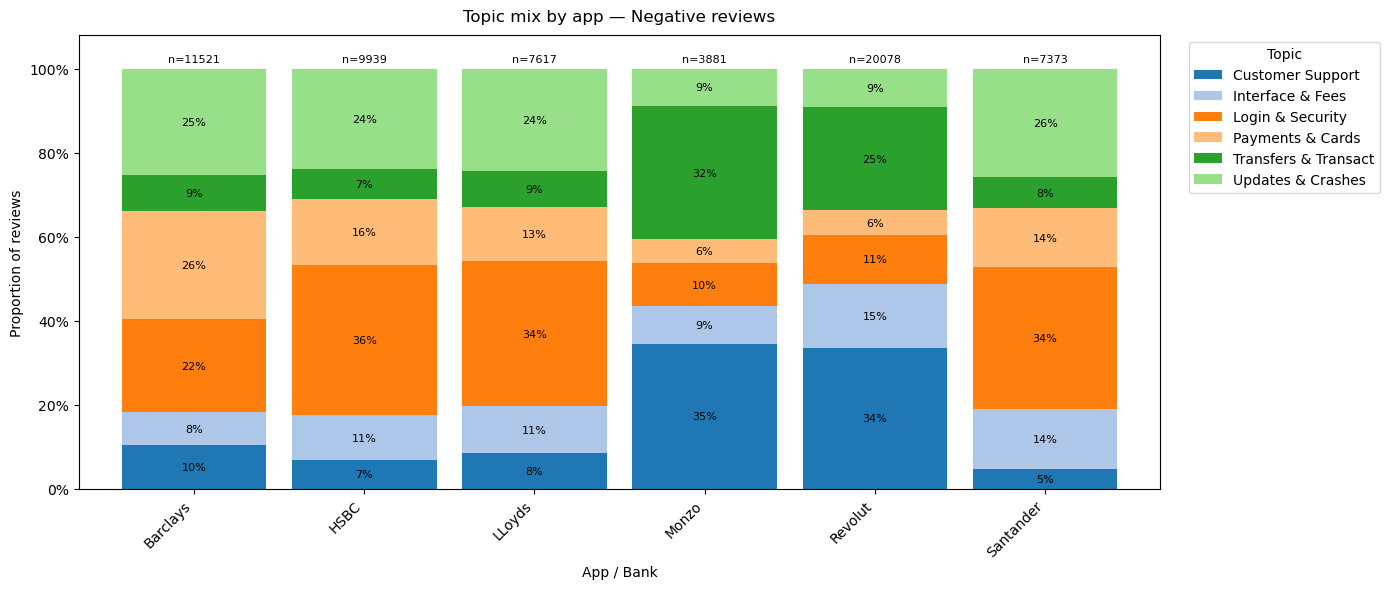

In [13]:
# Keep only rows where topic_label_ALL is not 'Undefined'
df_sub = df_final[df_final["topic_label_NEG"].notna()].copy()

# define topics, apps and colors
topics = sorted(df_sub['topic_label_NEG'].dropna().unique())
apps   = sorted(df_sub['app'].dropna().unique())

palette = plt.get_cmap('tab20').colors
topic_color = {t: palette[i % len(palette)] for i, t in enumerate(topics)}


# --- build data & plot ---
neg_shares, neg_totals = topic_share_by_app(df_sub, score = [1,2], label_col= 'topic_label_NEG', min_reviews=0)
plot_stacked(neg_shares, neg_totals, "Topic mix by app — Negative reviews")

### 4.3.3. - Positive reviews model

1️⃣ **Coherence sanity check** by evaluating a sample of reviews / labels

In [14]:
samples_df = sample_reviews_by_topic(df_final, topic_col= "topic_id_ALL",label_col= "topic_label_ALL", n=5, seed=40)
with pd.option_context('display.max_colwidth', None, 'display.width', None):
    display(samples_df)

,topic_id,topic_label,topic_prob,sample_text,score,sentiment
0,-1,Undefined,0.000000,Sweeeeeeet app,5,neutral
1,-1,Undefined,0.000000,"""we detected some suspicious activity"" when you actually need it it will ask for a verification on your little boy's size in inches, and a chat takes a month to solve",1,negative
2,-1,Undefined,0.000000,Fast,5,neutral
3,-1,Undefined,0.000000,Revolut has made life mush more easy,5,positive
4,-1,Undefined,0.000000,Excellent,5,positive
5,0,Fees & Service & Travel,0.571429,Exceptional!,5,neutral
6,0,Fees & Service & Travel,0.571429,Best service ever.,5,positive
7,0,Fees & Service & Travel,0.571429,great rates and great app,5,positive
8,0,Fees & Service & Travel,0.413686,All good. No problems Security excellent.,5,positive
9,0,Fees & Service & Travel,0.904543,"The app was good, but Revolut keeps changing it! I'm all for new features, but this is becoming ridiculous. I can no longer find tools I used to use such as the currency conversion tool.",1,negative


2️⃣ **Topic distribution per type of sentiment**

In [15]:
topic_sent = (df_final.groupby(["topic_id_POS","topic_label_POS","score"])
                        .size().unstack(fill_value=0))
topic_sent['total'] = topic_sent[4]+topic_sent[5]
topic_sent.sort_values('topic_id_POS', ascending=True)

,score,4,5,total
topic_id_POS,topic_label_POS,,,
0.0,Usability,3088,39444,42532
1.0,Features & Security,7776,38284,46060
2.0,Transactions & Money Mgmt,4928,37551,42479
3.0,Investments,5474,36995,42469
4.0,Cards & Travel,5633,47696,53329
5.0,Updates & Support,11297,35027,46324


3️⃣ **Topic distribution per app and scores**

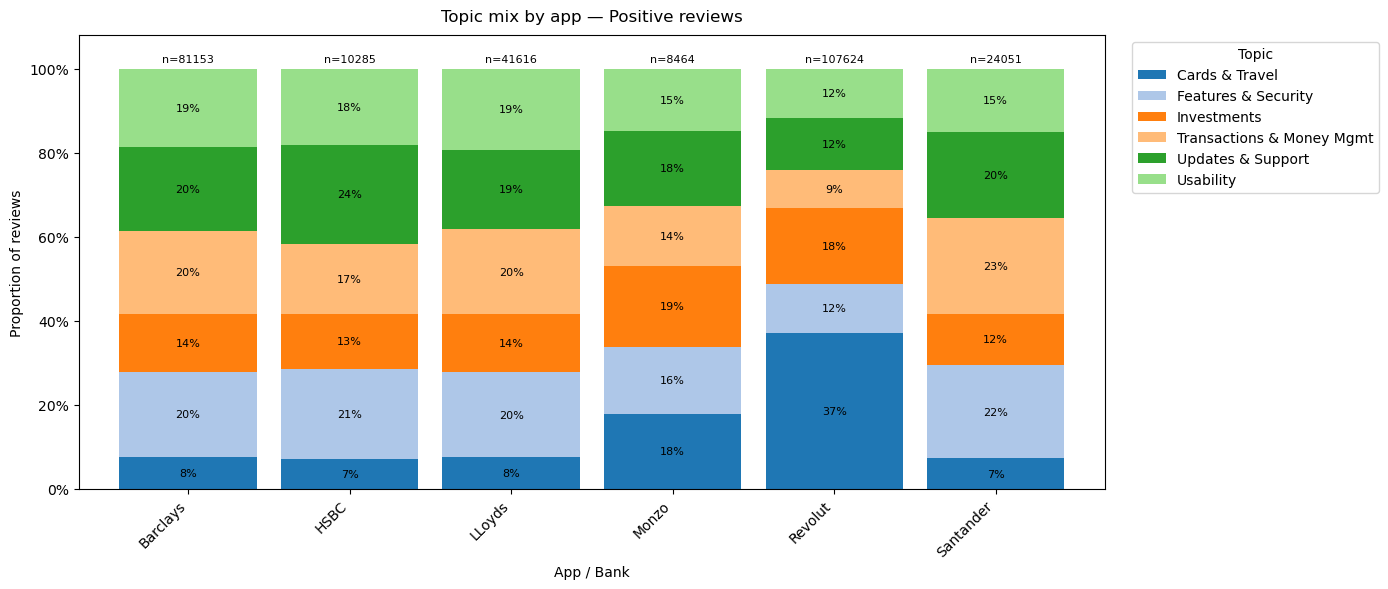

In [16]:
# Keep only rows where topic_label_ALL is not 'Undefined'
df_sub = df_final[df_final["topic_label_POS"].notna()].copy()

# define topics, apps and colors
topics = sorted(df_sub['topic_label_POS'].dropna().unique())
apps   = sorted(df_sub['app'].dropna().unique())

palette = plt.get_cmap('tab20').colors
topic_color = {t: palette[i % len(palette)] for i, t in enumerate(topics)}


# --- build data & plot ---
pos_shares, pos_totals = topic_share_by_app(df_sub, score = [4,5], label_col= 'topic_label_POS', min_reviews=0)
plot_stacked(pos_shares, pos_totals, "Topic mix by app — Positive reviews")